In [1]:
import sys
sys.path.append("..")

import pandas as pd
import ast  # Abstract Syntax Trees - safely parse string list to Python list
from reader import generic_reader
from inflation import read_cpi_by_year, convert_usd




In [2]:
cpi_by_year = read_cpi_by_year("inflation_data/cpiai.csv")
# cpi_by_year
convert_usd(1000, 2000, 2023, cpi_by_year)

1769

In [3]:
df_movies = generic_reader.read_csv_file_to_data_frame("../movie_data/movies.csv")
df_movies['genre_ids'] = df_movies['genre_ids'].apply(ast.literal_eval) # Turn genre_ids into actual Python list
df_movies['director_person_ids'] = df_movies['director_person_ids'].apply(ast.literal_eval) # Turn genre_ids into actual Python list
df_movies.info()
df_movies.sort_values(by="budget", ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2801 entries, 0 to 2800
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   adult                   2801 non-null   bool   
 1   backdrop_path           2800 non-null   object 
 2   budget                  2801 non-null   int64  
 3   homepage                1902 non-null   object 
 4   movie_id                2801 non-null   int64  
 5   imdb_id                 2800 non-null   object 
 6   origin_country          2801 non-null   object 
 7   original_language       2801 non-null   object 
 8   original_title          2801 non-null   object 
 9   overview                2801 non-null   object 
 10  popularity              2801 non-null   float64
 11  poster_path             2800 non-null   object 
 12  production_countries    2801 non-null   object 
 13  release_date            2801 non-null   object 
 14  revenue                 2801 non-null   

,adult,backdrop_path,budget,homepage,movie_id,imdb_id,origin_country,original_language,original_title,overview,...,vote_average,vote_count,director_person_ids,genre_ids,production_company_ids,collection_id,cast_person_ids,cast_credit_ids,crew_person_ids,crew_credit_ids
2646,False,/698FjyzLdpgXmUSr63LaRwblTmx.jpg,583900000,https://www.jurassicworld.com,507086,tt8041270,['US'],en,Jurassic World Dominion,"Four years after Isla Nublar was destroyed, di...",...,6.634,6669,[930707],"[12, 28, 878]","[56, 33]",328.0,"[73457, 18997, 4784, 4783, 4785, 206425, 16398...","['5b30ddfbc3a36853140012e7', '5b30de25c3a36853...","[1546026, 1084741, 3169987, 2825529, 491, 9307...","['607745d9fbe36f0042882c44', '607745c318864b00..."
2392,False,/SPkEiZGxq5aHWQ2Zw7AITwSEo2.jpg,416000000,https://www.starwars.com/films/star-wars-episo...,181812,tt2527338,['US'],en,Star Wars: The Rise of Skywalker,The surviving Resistance faces the First Order...,...,6.283,10364,[15344],"[12, 28, 878]","[1, 11461]",10.0,"[4, 2, 1315036, 1023139, 236695, 25072, 6, 153...","['5e867292e375c000143de939', '5e8671e404b59600...","[3084035, 3508489, 3555057, 2825529, 1110521, ...","['60997cee87e63e003b6b9811', '628726963d745400..."
1132,False,/uzIGtyS6bbnJzGsPL93WCF1FWm8.jpg,379000000,https://movies.disney.com/pirates-of-the-carib...,1865,tt1298650,"['US', 'GB']",en,Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,...,6.561,14499,[17633],"[12, 28, 14]","[2, 130, 20478]",295.0,"[85, 955, 118, 6972, 2449, 237455, 469759, 111...","['52fe431cc3a36847f803af13', '52fe431cc3a36847...","[770, 17633, 947, 1705, 1706, 406204, 1526463,...","['52fe431cc3a36847f803aedf', '52fe431cc3a36847..."
1663,False,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,365000000,https://www.marvel.com/movies/avengers-age-of-...,99861,tt2395427,['US'],en,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,...,7.300,23738,[12891],"[28, 12, 878]",[420],86311.0,"[3223, 74568, 103, 16828, 1245, 17604, 13548, ...","['55e256d292514162cd000e40', '52fe4a449251416c...","[608, 12891, 12891, 10850, 113675, 7624, 30306...","['60b188428ee49c006dc57b28', '52fe4a449251416c..."
2286,False,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,356000000,https://www.marvel.com/movies/avengers-endgame,299534,tt4154796,['US'],en,Avengers: Endgame,After the devastating events of Avengers: Infi...,...,8.238,26765,"[19272, 19271]","[12, 878, 28]",[420],86311.0,"[3223, 16828, 103, 74568, 1245, 17604, 16851, ...","['5e85cd735294e700134abf26', '5e85cd84691cd500...","[3019687, 57027, 3064294, 3062791, 4230717, 27...","['6057fbdf8c44b90054683688', '606f5c67dff66e00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,False,/AwB7HGeDTrBGkP2WEnNwg8Wa0E4.jpg,0,https://www.netflix.com/title/81212842,638974,tt15255288,['US'],en,Murder Mystery 2,"After starting their own detective agency, Nic...",...,6.402,1836,[59027],"[9648, 35, 80]","[878, 7382, 19367, 1205, 3574]",929336.0,"[19292, 4491, 2983, 19119, 1695989, 51878, 184...","['614fefb71c635b002a0d54ff', '614fefbfa5d84900...","[11699, 24529, 59027, 2161377, 162577, 102595,...","['6293f5f5fd630000663d1ea6', '650d09042c6b7b00..."
2730,False,/T5xXoFqyc9jNXZIbH4Sw0jwWjw.jpg,0,NaN,605886,tt10275534,['US'],en,To Catch a Killer,Baltimore. New Year's Eve. A talented but trou...,...,6.880,1189,[591600],"[53, 80, 18]","[7493, 106786]",NaN,"[94185, 77335, 1607522, 202032, 129419, 84832,...","['5cf066df92514169fdba1b82', '5fda1e35a3770a00...","[1020046, 2226015, 1486817, 1646476, 34338, 20...","['604e392fed96bc0029479ad7', '63f60de07dfda600..."
1712,False,/mLg1I7Nn47CYOdG1tOXegOhcayQ.jpg,0,NaN,339527,tt1291570,['US'],en,Solace,"A psychic doctor, John Clancy, works with an F...",...,6.421,2294,[1032011],"[53, 80, 9648]","[20313, 3604, 85885, 2273, 7493, 34081, 12075,...",NaN,"[4173, 47296, 37260, 72466, 98215, 20191, 6407...","['554e67fcc3a3681870002645', '55763788c3a36824...","[1407724, 1748851, 6898, 1399877, 2091399, 193...","

In [4]:
# Drop all movies which has more than one director:
df_movies = df_movies[df_movies['director_person_ids'].apply(lambda x: len(x) <= 1)]
df_movies['director'] = df_movies['director_person_ids'].apply(lambda x: x[0])

In [5]:
columns_to_keep = ['movie_id', 'original_title', 'release_date', 'budget', 'revenue', 'vote_average', 'vote_count', 'director', 'director_person_ids', 'genre_ids']
df_movies = df_movies[columns_to_keep].copy()
df_movies

,movie_id,original_title,release_date,budget,revenue,vote_average,vote_count,director,director_person_ids,genre_ids
1,10898,The Little Mermaid II: Return to the Sea,2000-01-23,0,0,6.397,1747,60725,[60725],"[16, 12, 10751, 35]"
2,4234,Scream 3,2000-02-04,40000000,161834276,5.995,3807,5140,[5140],"[27, 9648]"
3,2787,Pitch Black,2000-02-18,23000000,53187659,6.851,4599,28239,[28239],"[53, 878, 28]"
4,2069,The Whole Nine Yards,2000-02-18,41300000,106371651,6.465,1970,21217,[21217],"[35, 80]"
5,2067,Mission to Mars,2000-03-10,90000000,110983407,6.000,1494,1150,[1150],"[878, 12, 18]"
...,...,...,...,...,...,...,...,...,...,...
2796,848326,Rebel Moon - Part One: A Child of Fire,2023-12-15,83000000,0,6.242,2385,15217,[15217],"[878, 28, 12]"
2797,467244,The Zone of Interest,2023-12-15,15000000,52631884,7.005,2304,66728,[66728],"[18, 36, 10752]"
2798,572802,Aquaman and the Lost Kingdom,2023-12-20,205000000,440181226,6.600,3223,2127,[2127],"[28, 12, 14]"
2799,1072790,Anyone But You,2023-12-21,25000000,214891370,6.837,2735,82511,[82511],"[10749, 35]"


In [6]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2582 entries, 1 to 2800
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   movie_id             2582 non-null   int64  
 1   original_title       2582 non-null   object 
 2   release_date         2582 non-null   object 
 3   budget               2582 non-null   int64  
 4   revenue              2582 non-null   int64  
 5   vote_average         2582 non-null   float64
 6   vote_count           2582 non-null   int64  
 7   director             2582 non-null   int64  
 8   director_person_ids  2582 non-null   object 
 9   genre_ids            2582 non-null   object 
dtypes: float64(1), int64(5), object(4)
memory usage: 221.9+ KB


In [7]:
df_movies['genre_ids'].apply(type).value_counts()

genre_ids
<class 'list'>    2582
Name: count, dtype: int64

In [8]:
df_movies = df_movies[(df_movies['budget'] != 0) & (df_movies['revenue'] != 0)].copy()

In [9]:
# Convert release_data into proper datetime objects
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])

# Create year column
df_movies['release_year'] = df_movies['release_date'].dt.year

In [10]:
# Convert budget to 2023 USD
df_movies['budget_2023_usd'] = df_movies.apply(
    lambda row: convert_usd(
        original_amount=row['budget'],
        original_year=row['release_year'],
        new_year=2023,
        cpi_by_year=cpi_by_year
    ),
    axis=1
)

# Convert revenue to 2023 USD
df_movies['revenue_2023_usd'] = df_movies.apply(
    lambda row: convert_usd(
        original_amount=row['revenue'],
        original_year=row['release_year'],
        new_year=2023,
        cpi_by_year=cpi_by_year
    ),
    axis=1
)

In [11]:
df_movies
df_movies.sort_values(by="budget_2023_usd", ascending=False)

,movie_id,original_title,release_date,budget,revenue,vote_average,vote_count,director,director_person_ids,genre_ids,release_year,budget_2023_usd,revenue_2023_usd
2646,507086,Jurassic World Dominion,2022-06-01,583900000,1004004592,6.634,6669,930707,[930707],"[12, 28, 878]",2022,607935300,1045332818
1132,1865,Pirates of the Caribbean: On Stranger Tides,2011-05-15,379000000,1046721266,6.561,14499,17633,[17633],"[12, 28, 14]",2011,513391695,1417883919
2392,181812,Star Wars: The Rise of Skywalker,2019-12-18,416000000,1074144248,6.283,10364,15344,[15344],"[12, 28, 878]",2019,495803565,1280203240
1663,99861,Avengers: Age of Ultron,2015-04-22,365000000,1405403694,7.300,23738,12891,[12891],"[28, 12, 878]",2015,469232494,1806742684
651,285,Pirates of the Caribbean: At World's End,2007-05-19,300000000,961691209,7.262,14940,1704,[1704],"[12, 14, 28]",2007,440867221,1413260435
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,980078,Winnie the Pooh: Blood and Honey,2023-01-26,100000,7717044,5.000,1491,3122176,[3122176],"[27, 53]",2023,100000,7717044
1450,220289,Coherence,2013-09-19,50000,139745,7.200,3165,146439,[146439],"[53, 878]",2013,65399,182783
2089,420634,Terrifier,2018-01-25,35000,421798,6.342,2776,933176,[933176],"[27, 53]",2018,42470,511824
688,23827,Paranormal Activity,2007-09-14,15000,193355800,6.000,5225,90591,[90591],"[27, 9648]",2007,22043,284147447


Calculate profit and ROI

In [12]:
df_movies['profit_2023_usd'] = df_movies['revenue_2023_usd'] - df_movies['budget_2023_usd']
df_movies['roi'] = ( df_movies['profit_2023_usd'] / df_movies['budget_2023_usd'] )*100
df_movies.sort_values(by="profit_2023_usd", ascending=False)

,movie_id,original_title,release_date,budget,revenue,vote_average,vote_count,director,director_person_ids,genre_ids,release_year,budget_2023_usd,revenue_2023_usd,profit_2023_usd,roi
956,19995,Avatar,2009-12-15,237000000,2923706026,7.594,32649,2710,[2710],"[28, 12, 14, 878]",2009,336605225,4152467198,3815861973,1133.631236
1758,140607,Star Wars: The Force Awakens,2015-12-15,245000000,2068223624,7.256,19981,15344,[15344],"[12, 28, 878]",2015,314964276,2658843091,2343878815,744.172909
2707,76600,Avatar: The Way of Water,2022-12-14,350000000,2320250281,7.610,12891,2710,[2710],"[878, 12, 28]",2022,364407184,2415759634,2051352450,562.928652
1680,135397,Jurassic World,2015-06-06,150000000,1671537444,6.699,21018,930707,[930707],"[28, 12, 878, 53]",2015,192835271,2148875843,1956040572,1014.358298
2608,634649,Spider-Man: No Way Home,2021-12-15,200000000,1921847111,7.939,21144,1293994,[1293994],"[28, 12, 878]",2021,224897121,2161089412,1936192291,860.923556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,508943,Luca,2021-06-17,200000000,51074773,7.794,8677,930567,[930567],"[16, 35, 14, 12, 10751]",2021,224897121,57432847,-167464274,-74.462614
2780,800158,The Killer,2023-10-25,175000000,362113,6.572,2501,7467,[7467],"[80, 53]",2023,175000000,362113,-174637887,-99.793078
2592,512195,Red Notice,2021-11-04,160000000,178143,6.757,6115,57633,[57633],"[28, 35, 80]",2021,179917697,200319,-179717378,-99.888661
2372,398978,The Irishman,2019-11-01,159000000,968853,7.583,7175,1032,[1032],"[80, 18, 36]",2019,189501843,1154713,-188347130,-99.390659


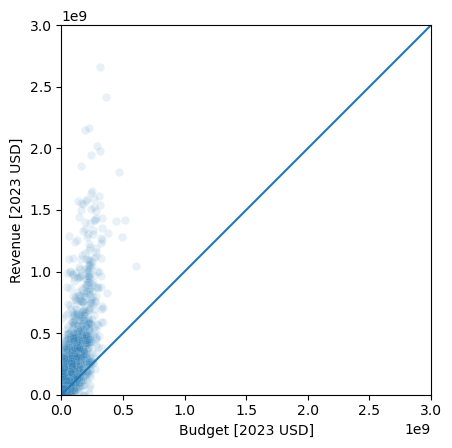

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=df_movies['budget_2023_usd'], y=df_movies['revenue_2023_usd'], alpha=0.1)
plt.xlim(0, 3e9)
plt.ylim(0, 3e9)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0, 3e9], [0, 3e9])
plt.xlabel("Budget [2023 USD]")
plt.ylabel("Revenue [2023 USD]");

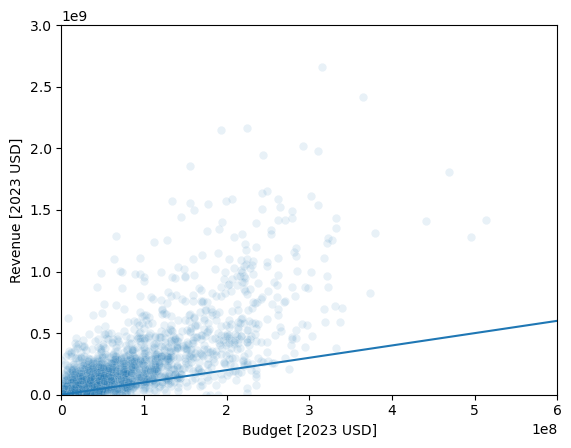

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=df_movies['budget_2023_usd'], y=df_movies['revenue_2023_usd'], alpha=0.1)
plt.xlim(0, 0.6e9)
plt.ylim(0, 3e9)
# plt.gca().set_aspect('equal', adjustable='box')
plt.plot([0, 3e9], [0, 3e9])
plt.xlabel("Budget [2023 USD]")
plt.ylabel("Revenue [2023 USD]");

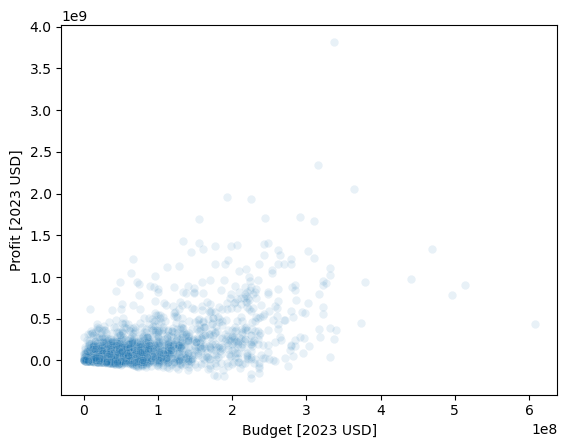

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=df_movies['budget_2023_usd'], y=df_movies['profit_2023_usd'], alpha=0.1)
# plt.xlim(0, 0.6e9)
# plt.ylim(0, 3e9)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.plot([0, 3e9], [0, 3e9])
plt.xlabel("Budget [2023 USD]")
plt.ylabel("Profit [2023 USD]");

<Axes: xlabel='budget_2023_usd', ylabel='vote_average'>

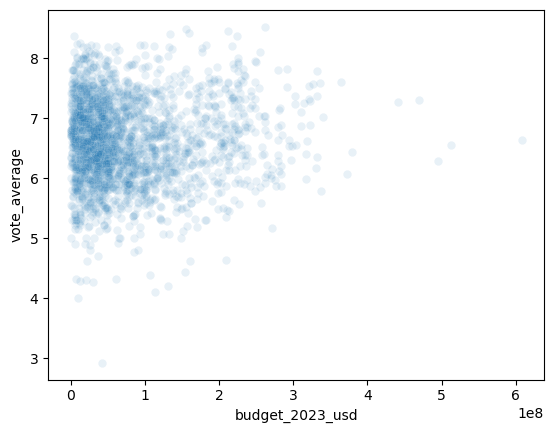

In [16]:
sns.scatterplot(x=df_movies['budget_2023_usd'], y=df_movies['vote_average'], alpha=0.1)

<Axes: xlabel='profit_2023_usd', ylabel='vote_average'>

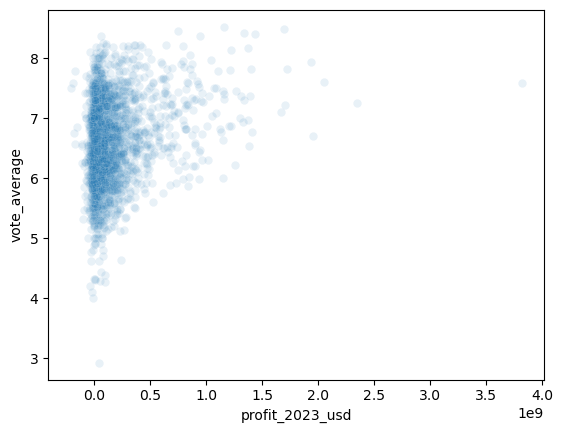

In [17]:
sns.scatterplot(x=df_movies['profit_2023_usd'], y=df_movies['vote_average'], alpha=0.1)

(-100.0, 2000.0)

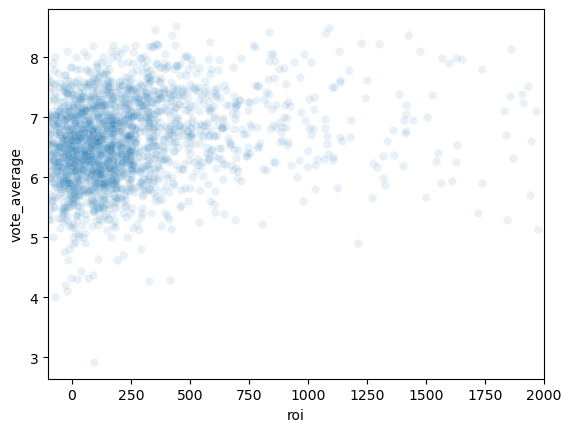

In [18]:
sns.scatterplot(x=df_movies['roi'], y=df_movies['vote_average'], alpha=0.1)
plt.xlim(-100, 2000)

In [19]:
# Define a function for rating_category
def get_rating_category(vote_average):
    if vote_average >= 7:
        return "good";
    if vote_average >= 5:
        return "ok";
    else:
        return "bad";

# Apply the function to df_movies 
df_movies['rating_category'] = df_movies['vote_average'].apply(get_rating_category)
df_movies.sort_values(by="vote_average", ascending=False)

,movie_id,original_title,release_date,budget,revenue,vote_average,vote_count,director,director_person_ids,genre_ids,release_year,budget_2023_usd,revenue_2023_usd,profit_2023_usd,roi,rating_category
783,155,The Dark Knight,2008-07-16,185000000,1004558444,8.523,34459,525,[525],"[18, 28, 80, 53]",2008,261816713,1421676703,1159859990,443.004565,good
309,122,The Lord of the Rings: The Return of the King,2003-12-17,94000000,1118888979,8.489,25485,108,[108],"[12, 14, 28]",2003,155698023,1853285129,1697587106,1090.307425,good
1601,157336,Interstellar,2014-11-05,165000000,746606706,8.461,37933,525,[525],"[12, 18, 878]",2014,212370429,960952645,748582216,352.488913,good
138,120,The Lord of the Rings: The Fellowship of the Ring,2001-12-18,93000000,871368364,8.425,26413,108,[108],"[12, 14, 28]",2001,160037164,1499476582,1339439418,836.955232,good
221,121,The Lord of the Rings: The Two Towers,2002-12-18,79000000,926287400,8.409,22943,108,[108],"[12, 14, 28]",2002,133823072,1569096525,1435273453,1072.515697,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,10073,Date Movie,2006-02-17,20000000,85749034,4.277,1015,35734,[35734],"[35, 10749]",2006,30229581,129607870,99378289,328.745175,bad
419,10214,Son of the Mask,2005-02-11,84000000,59918422,4.200,1892,64191,[64191],"[14, 35, 10751, 12]",2005,131060037,93487031,-37573006,-28.668545,bad
2393,536869,Cats,2019-12-19,95000000,77276321,4.100,1014,70500,[70500],"[14, 35, 18]",2019,113224372,92100662,-21123710,-18.656504,bad
263,17473,The Room,2003-06-27,6000000,1752988,4.013,1454,81916,[81916],"[18, 10749]",2003,9938172,2903583,-7034589,-70.783530,bad


In [20]:
# # Drop all movies with rating 'bad'
# df_movies = df_movies[df_movies['rating_category'] != 'bad'].copy()

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Encode target variable
le_rating = LabelEncoder()
df_movies['rating_encoded'] = le_rating.fit_transform(df_movies['rating_category'])
df_movies

# Independet variables (X) and dependent variable (y)
X = df_movies[['budget', 'director']]
y = df_movies['rating_encoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Train model
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred, target_names=le_rating.classes_))

              precision    recall  f1-score   support

         bad       0.00      0.00      0.00         4
        good       0.48      0.33      0.39       143
          ok       0.71      0.83      0.77       299

    accuracy                           0.66       446
   macro avg       0.40      0.39      0.39       446
weighted avg       0.63      0.66      0.64       446



c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
